### Importing relevant libraries


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imutils import paths
from skimage.feature import hog
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_validate
import seaborn as sns
import imutils
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

### Connecting google colab to google drive to access the data sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Defining some functions

In [ ]:
# create_path_list allows us to generate a list of images paths from a folder
def create_path_list(path):
  return list(paths.list_images(path))

# read_data allows us to read our data set from the path_list and store it in an array
def read_data(path_list):
  height_lst = [] # to store the height of the image
  width_lst = [] # to store the width of the image
  result = [] # to store the image
  for path in path_list:
    image = cv2.imread(path)
    height, width, _ = image.shape
    height_lst.append(height)
    width_lst.append(width)
    if _ == 3: # to check whether the image is colored or gray scale
      colored = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB since openCV reads in image in BGR format
      result.append(colored)
  return result, height_lst, width_lst

def resize(image_list, size):
  result = []
  for image in image_list:
    result.append(cv2.resize(image, size))
  return result

# create_label is used to create the "y array"
def create_label(input, label):
  return np.full((len(input), ), label)

def flatten(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image.flatten()

def calculate_histogram(image):
    # calculate histograms for each channel (Red, Green, Blue)
    red = cv2.calcHist([image], [0], None, [256], [0, 256])
    green = cv2.calcHist([image], [1], None, [256], [0, 256])
    blue = cv2.calcHist([image], [2], None, [256], [0, 256])

    # concatenate the histograms into a single feature vector
    hist_features = np.concatenate([red, green, blue], axis = None)

    return hist_features

def calculate_hog(image):
    resized = cv2.resize(image, (64, 128)) # resized to this size according to a research paper
    gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY) # changed to grayscale also according to a research paper

    features, _ = hog(gray, orientations = 9, pixels_per_cell = (8, 8),
                      cells_per_block = (2,2), transform_sqrt = True,
                      block_norm = "L2-Hys", visualize = True)
    return features

# train a model using X_train and y_train and evaluate it with X_test and y_test using classification report
def run_model(model, X_train, X_test, y_train, y_test):
  clf = model.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))

# conduct 5_fold validation given X_train and y_train, reporting accuracy, recall and f1
def k_fold_val(model, X_train, y_train):
  k_folds = StratifiedKFold(n_splits = 5)
  scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
             'f1': make_scorer(f1_score)}

  scores = cross_validate(model, X_train, y_train, cv = k_folds, scoring = scoring)

  print(f"Average CV Accuracy: {scores['test_accuracy'].mean()}")
  print(f"Average CV Recall: {scores['test_recall'].mean()}")
  print(f"Average CV F1_score: {scores['test_f1'].mean()}")

# Data Processing and Feature Extraction



We first read in the data set and store it in an array using pre-defined functions above. Here, we have also recorded the height and width of each image and we will visualize them in the next section.

In [ ]:
benign, height_benign, width_benign = read_data(create_path_list("/content/drive/MyDrive/Brain Tumor/data/benign"))
malignant, height_mal, width_mal = read_data(create_path_list("/content/drive/MyDrive/Brain Tumor/data/malignant"))

We then visualize the distribution of the height and width of image data set and notice that most images were of height and width between 200 and 400 pixels

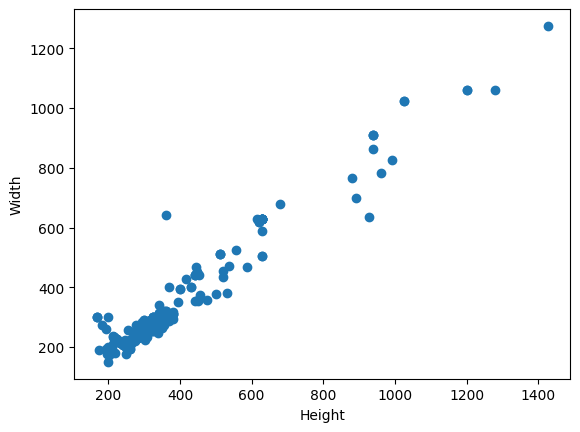

In [ ]:
height = height_benign + height_mal
width = width_benign + width_mal

plt.scatter(height, width)
plt.xlabel("Height")
plt.ylabel("Width")
plt.show()

We then inspect the number of benign and malignant data and found that the data set may not be very balanced. We will deal with this in a later section

In [ ]:
print(f"Number of benign data: {len(benign)}")
print(f"Number of malignant data: {len(malignant)}")

Number of benign data: 77
Number of malignant data: 154


We will now prepare the X and y array for training and testing using train_test_split. But to do that, we will first concatenate the benign and malignant array after resizing them to (224,224,3) to match the dimension. We also create their labels accordingly. Stratified split was used to make sure that both train and test data sets have the same proportion of benign and malignant data.

In [ ]:
combined = np.concatenate([resize(benign, (224,224)), resize(malignant, (224,224))]) # image size from plot and research papers

y1 = create_label(benign, 0)
y2 = create_label(malignant, 1)
Y = np.concatenate([y1, y2])

trainX, testX, trainY, testY = train_test_split(combined, Y, test_size = 0.20, random_state = 3, stratify = Y)

In [ ]:
print(f"Number of benign: {np.sum(trainY == 0)}")
print(f"Number of malignant: {np.sum(trainY == 1)}")

Number of benign: 61
Number of malignant: 123


The following code helps us prepare the respective features (flattened image, histogram, histogram of oriented gradients) for training and testing using pre-defined functions.

In [ ]:
trainX_flattened = np.array(list(map(flatten, trainX))) / 255
testX_flattened = np.array(list(map(flatten, testX))) / 255

trainX_hist = np.array(list(map(calculate_histogram, trainX)))
testX_hist = np.array(list(map(calculate_histogram, testX)))

trainX_hog = np.array(list(map(calculate_hog, trainX)))
testX_hog = np.array(list(map(calculate_hog, testX)))

We then prepare the features extracted from pre-training schemes. We have chosen VGG19 for this project. The following code will load the pre-trained model and a summary of the model is provided.

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input

image_size = (224, 224, 3)

vgg = VGG19(input_shape = image_size, weights = 'imagenet', include_top = False)

for layer in vgg.layers:
  layer.trainable = False

vgg.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

The following code extracts features from VGG19 pre-trained model by passing our images through the loaded model.

In [ ]:
trainX_vgg = preprocess_input(trainX)
testX_vgg = preprocess_input(testX)

feature_extractor_train = vgg.predict(trainX_vgg)
feature_extractor_test = vgg.predict(testX_vgg)

feature_train = feature_extractor_train.reshape(feature_extractor_train.shape[0], -1)
feature_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)

2/2 [==============================] - 36s 11s/step


We then standardized all features before fitting them into our models

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

trainX_vgg = scaler.fit_transform(feature_train)
testX_vgg = scaler.transform(feature_test)

trainX_flattened = trainX_flattened / 255
testX_flattened = testX_flattened / 255

trainX_hist = trainX_hist / 255
testX_hist = testX_hist / 255

# Model Fitting

## KNN

We have chosen n_neighbors = 14 as it is a general rule of thumb to use sqrt(n) as the number of neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knnModel = KNeighborsClassifier(n_neighbors = 14)

k_fold_val(knnModel, trainX_flattened, trainY)
run_model(knnModel, trainX_flattened, testX_flattened, trainY, testY)

k_fold_val(knnModel, trainX_hist, trainY)
run_model(knnModel, trainX_hist, testX_hist, trainY, testY)

k_fold_val(knnModel, trainX_hog, trainY)
run_model(knnModel, trainX_hog, testX_hog, trainY, testY)

k_fold_val(knnModel, trainX_vgg, trainY)
run_model(knnModel, trainX_vgg, testX_vgg, trainY, testY)


Average CV Accuracy: 0.7064564564564565
Average CV Recall: 0.717
Average CV F1_score: 0.7602894539583694
              precision    recall  f1-score   support

           0       0.55      0.75      0.63        16
           1       0.84      0.68      0.75        31

    accuracy                           0.70        47
   macro avg       0.69      0.71      0.69        47
weighted avg       0.74      0.70      0.71        47

Average CV Accuracy: 0.6953453453453454
Average CV Recall: 0.9833333333333334
Average CV F1_score: 0.8119570250995647
              precision    recall  f1-score   support

           0       0.50      0.12      0.20        16
           1       0.67      0.94      0.78        31

    accuracy                           0.66        47
   macro avg       0.59      0.53      0.49        47
weighted avg       0.62      0.66      0.59        47

Average CV Accuracy: 0.7558558558558559
Average CV Recall: 0.8703333333333333
Average CV F1_score: 0.8274908424908425
     

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# HOG
LRModel = LogisticRegression(max_iter = 10000)

k_fold_val(LRModel, trainX_flattened, trainY)
run_model(LRModel, trainX_flattened, testX_flattened, trainY, testY)

k_fold_val(LRModel, trainX_hist, trainY)
run_model(LRModel, trainX_hist, testX_hist, trainY, testY)

k_fold_val(LRModel, trainX_hog, trainY)
run_model(LRModel, trainX_hog, testX_hog, trainY, testY)

k_fold_val(LRModel, trainX_vgg, trainY)
run_model(LRModel, trainX_vgg, testX_vgg, trainY, testY)


Average CV Accuracy: 0.6684684684684685
Average CV Recall: 1.0
Average CV F1_score: 0.8012480169222632


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.66      1.00      0.79        31

    accuracy                           0.66        47
   macro avg       0.33      0.50      0.40        47
weighted avg       0.44      0.66      0.52        47

Average CV Accuracy: 0.7930930930930931
Average CV Recall: 0.8376666666666667
Average CV F1_score: 0.8429020457539025
              precision    recall  f1-score   support

           0       0.36      0.25      0.30        16
           1       0.67      0.77      0.72        31

    accuracy                           0.60        47
   macro avg       0.52      0.51      0.51        47
weighted avg       0.56      0.60      0.57        47

Average CV Accuracy: 0.8424924924924925
Average CV Recall: 0.951
Average CV F1_score: 0.889980679199008
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        16
           1   

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

k_fold_val(rfc, trainX_flattened, trainY)
run_model(rfc, trainX_flattened, testX_flattened, trainY, testY)

k_fold_val(rfc, trainX_hist, trainY)
run_model(rfc, trainX_hist, testX_hist, trainY, testY)

k_fold_val(rfc, trainX_hog, trainY)
run_model(rfc, trainX_hog, testX_hog, trainY, testY)

k_fold_val(rfc, trainX_vgg, trainY)
run_model(rfc, trainX_vgg, testX_vgg, trainY, testY)

Average CV Accuracy: 0.8042042042042044
Average CV Recall: 0.9106666666666665
Average CV F1_score: 0.8601219744615971
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        16
           1       0.87      0.87      0.87        31

    accuracy                           0.83        47
   macro avg       0.81      0.81      0.81        47
weighted avg       0.83      0.83      0.83        47

Average CV Accuracy: 0.7606606606606607
Average CV Recall: 0.8699999999999999
Average CV F1_score: 0.8295011241071174
              precision    recall  f1-score   support

           0       0.80      0.50      0.62        16
           1       0.78      0.94      0.85        31

    accuracy                           0.79        47
   macro avg       0.79      0.72      0.73        47
weighted avg       0.79      0.79      0.77        47

Average CV Accuracy: 0.8207207207207207
Average CV Recall: 0.9513333333333334
Average CV F1_score: 0.876410330

## Support Vector Machines

In [ ]:
from sklearn.svm import SVC

svc = SVC()

k_fold_val(svc, trainX_flattened, trainY)
run_model(svc, trainX_flattened, testX_flattened, trainY, testY)

k_fold_val(svc, trainX_hist, trainY)
run_model(svc, trainX_hist, testX_hist, trainY, testY)

k_fold_val(svc, trainX_hog, trainY)
run_model(svc, trainX_hog, testX_hog, trainY, testY)

k_fold_val(svc, trainX_vgg, trainY)
run_model(svc, trainX_vgg, testX_vgg, trainY, testY)

Average CV Accuracy: 0.7774774774774775
Average CV Recall: 0.8933333333333333
Average CV F1_score: 0.8417280883367839
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        16
           1       0.83      0.94      0.88        31

    accuracy                           0.83        47
   macro avg       0.83      0.78      0.80        47
weighted avg       0.83      0.83      0.82        47

Average CV Accuracy: 0.7444444444444445
Average CV Recall: 0.9506666666666665
Average CV F1_score: 0.8323632641575365
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        16
           1       0.79      1.00      0.89        31

    accuracy                           0.83        47
   macro avg       0.90      0.75      0.78        47
weighted avg       0.86      0.83      0.81        47

Average CV Accuracy: 0.8207207207207207
Average CV Recall: 0.9426666666666665
Average CV F1_score: 0.875450693

We can see that for all models, hog features and vgg features seem to perform much better than flattened features and color histogram features. This is expected and will be discussed in our report.

# Further Data Processing (cropping)

To further improve our models, we try to pre-process our images by cropping the black space out.

In the interest of optimising our workflow and maximising efficiency, we only attempted cropping with the classical ML models and checked whether the performance improved. Since, this wasn't the case, we did not do it for our DL models.

This part of code is adopted from https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/

In [ ]:
def crop(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    threshold = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_img = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
    return cv2.resize(new_img, (224, 224)) # image size from plot and research papers.

In [ ]:
benign_crop = np.array(list(map(crop, benign)))
malignant_crop = np.array(list(map(crop, malignant)))

We then repeat the same steps as per above to check whether the performance would improve.

In [ ]:
combined_crop = np.concatenate([benign_crop, malignant_crop])

trainX_crop, testX_crop, trainY_crop, testY_crop = train_test_split(combined_crop, Y, test_size = 0.20, random_state = 3, stratify = Y)

trainX_crop_flattened = np.array(list(map(flatten, trainX_crop))) / 255
testX_crop_flattened = np.array(list(map(flatten, testX_crop))) / 255

trainX_crop_hist = np.array(list(map(calculate_histogram, trainX_crop)))
testX_crop_hist = np.array(list(map(calculate_histogram, testX_crop)))

trainX_crop_hog = np.array(list(map(calculate_hog, trainX_crop)))
testX_crop_hog = np.array(list(map(calculate_hog, testX_crop)))

trainX_crop_vgg = preprocess_input(trainX_crop)
testX_crop_vgg = preprocess_input(testX_crop)

feature_extractor_train_crop = vgg.predict(trainX_crop_vgg)
feature_extractor_test_crop = vgg.predict(testX_crop_vgg)

feature_train_crop = feature_extractor_train_crop.reshape(feature_extractor_train_crop.shape[0], -1)
feature_test_crop = feature_extractor_test_crop.reshape(feature_extractor_test_crop.shape[0], -1)

scaler = MinMaxScaler()

trainX_crop_vgg = scaler.fit_transform(feature_train_crop)
testX_crop_vgg = scaler.transform(feature_test_crop)

trainX_crop_flattened = trainX_crop_flattened / 255
testX_crop_flattened = testX_crop_flattened / 255

trainX_crop_hist = trainX_crop_hist / 255
testX_crop_hist = testX_crop_hist / 255

2/2 [==============================] - 42s 12s/step


## KNN with cropped data

In [ ]:
k_fold_val(knnModel, trainX_crop_flattened, trainY_crop)
run_model(knnModel, trainX_crop_flattened, testX_crop_flattened, trainY_crop, testY_crop)

k_fold_val(knnModel, trainX_crop_hist, trainY_crop)
run_model(knnModel, trainX_crop_hist, testX_crop_hist, trainY_crop, testY_crop)

k_fold_val(knnModel, trainX_crop_hog, trainY_crop)
run_model(knnModel, trainX_crop_hog, testX_crop_hog, trainY_crop, testY_crop)

k_fold_val(knnModel, trainX_crop_vgg, trainY_crop)
run_model(knnModel, trainX_crop_vgg, testX_crop_vgg, trainY_crop, testY_crop)


Average CV Accuracy: 0.5816816816816817
Average CV Recall: 0.6436666666666666
Average CV F1_score: 0.6700418127128545
              precision    recall  f1-score   support

           0       0.27      0.38      0.32        16
           1       0.60      0.48      0.54        31

    accuracy                           0.45        47
   macro avg       0.44      0.43      0.43        47
weighted avg       0.49      0.45      0.46        47

Average CV Accuracy: 0.7121621621621621
Average CV Recall: 0.951
Average CV F1_score: 0.8150166773117593
              precision    recall  f1-score   support

           0       0.67      0.12      0.21        16
           1       0.68      0.97      0.80        31

    accuracy                           0.68        47
   macro avg       0.67      0.55      0.51        47
weighted avg       0.68      0.68      0.60        47

Average CV Accuracy: 0.6142642642642643
Average CV Recall: 0.5123333333333333
Average CV F1_score: 0.6349771620359856
     

## Logistic Regression with cropped data

In [ ]:
k_fold_val(LRModel, trainX_crop_flattened, trainY_crop)
run_model(LRModel, trainX_crop_flattened, testX_crop_flattened, trainY_crop, testY_crop)

k_fold_val(LRModel, trainX_crop_hist, trainY_crop)
run_model(LRModel, trainX_crop_hist, testX_crop_hist, trainY_crop, testY_crop)

k_fold_val(LRModel, trainX_crop_hog, trainY_crop)
run_model(LRModel, trainX_crop_hog, testX_crop_hog, trainY_crop, testY_crop)

k_fold_val(LRModel, trainX_crop_vgg, trainY_crop)
run_model(LRModel, trainX_crop_vgg, testX_crop_vgg, trainY_crop, testY_crop)


Average CV Accuracy: 0.6684684684684685
Average CV Recall: 1.0
Average CV F1_score: 0.8012480169222632


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.66      1.00      0.79        31

    accuracy                           0.66        47
   macro avg       0.33      0.50      0.40        47
weighted avg       0.44      0.66      0.52        47

Average CV Accuracy: 0.6636636636636636
Average CV Recall: 0.764
Average CV F1_score: 0.7499449564895688
              precision    recall  f1-score   support

           0       0.64      0.44      0.52        16
           1       0.75      0.87      0.81        31

    accuracy                           0.72        47
   macro avg       0.69      0.65      0.66        47
weighted avg       0.71      0.72      0.71        47

Average CV Accuracy: 0.787987987987988
Average CV Recall: 0.8779999999999999
Average CV F1_score: 0.8459186518760987
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1   

## Random Forest Classifier with cropped data

In [ ]:
k_fold_val(rfc, trainX_crop_flattened, trainY_crop)
run_model(rfc, trainX_crop_flattened, testX_crop_flattened, trainY_crop, testY_crop)

k_fold_val(rfc, trainX_crop_hist, trainY_crop)
run_model(rfc, trainX_crop_hist, testX_crop_hist, trainY_crop, testY_crop)

k_fold_val(rfc, trainX_crop_hog, trainY_crop)
run_model(rfc, trainX_crop_hog, testX_crop_hog, trainY_crop, testY_crop)

k_fold_val(rfc, trainX_crop_vgg, trainY_crop)
run_model(rfc, trainX_crop_vgg, testX_crop_vgg, trainY_crop, testY_crop)


Average CV Accuracy: 0.75
Average CV Recall: 0.9106666666666665
Average CV F1_score: 0.8302434656952625
              precision    recall  f1-score   support

           0       0.57      0.50      0.53        16
           1       0.76      0.81      0.78        31

    accuracy                           0.70        47
   macro avg       0.66      0.65      0.66        47
weighted avg       0.69      0.70      0.70        47

Average CV Accuracy: 0.7447447447447447
Average CV Recall: 0.893
Average CV F1_score: 0.8217479535422259
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        16
           1       0.74      0.74      0.74        31

    accuracy                           0.66        47
   macro avg       0.62      0.62      0.62        47
weighted avg       0.66      0.66      0.66        47

Average CV Accuracy: 0.7503003003003004
Average CV Recall: 0.9436666666666668
Average CV F1_score: 0.8341638401320626
              preci

## Support Vector Machines with cropped data

In [ ]:
k_fold_val(svc, trainX_crop_flattened, trainY_crop)
run_model(svc, trainX_crop_flattened, testX_crop_flattened, trainY_crop, testY_crop)

k_fold_val(svc, trainX_crop_hist, trainY_crop)
run_model(svc, trainX_crop_hist, testX_crop_hist, trainY_crop, testY_crop)

k_fold_val(svc, trainX_crop_hog, trainY_crop)
run_model(svc, trainX_crop_hog, testX_crop_hog, trainY_crop, testY_crop)

k_fold_val(svc, trainX_crop_vgg, trainY_crop)
run_model(svc, trainX_crop_vgg, testX_crop_vgg, trainY_crop, testY_crop)


Average CV Accuracy: 0.6846846846846847
Average CV Recall: 0.967
Average CV F1_score: 0.8035133216016795
              precision    recall  f1-score   support

           0       0.60      0.19      0.29        16
           1       0.69      0.94      0.79        31

    accuracy                           0.68        47
   macro avg       0.65      0.56      0.54        47
weighted avg       0.66      0.68      0.62        47

Average CV Accuracy: 0.7339339339339339
Average CV Recall: 0.9506666666666665
Average CV F1_score: 0.8269824973356554
              precision    recall  f1-score   support

           0       0.60      0.19      0.29        16
           1       0.69      0.94      0.79        31

    accuracy                           0.68        47
   macro avg       0.65      0.56      0.54        47
weighted avg       0.66      0.68      0.62        47

Average CV Accuracy: 0.7555555555555555
Average CV Recall: 0.959
Average CV F1_score: 0.8395484161702746
              prec

By comparing the performance, we see that while cropping seems to be a good data preprocessing step, it did not improve our performance as compared to not cropping. In the next station we will try some data augmentation

# Data Augmentation

Since the dataset is not balanced (more malignant than benign), we decided to augment some benign data by flipping the images horizontally. We did not consider further augmenting the data by fipping them vertically or rotating them. Note that we only performed augmentation on the train data set.

In the interest of optimising our workflow and maximising efficiency, we only attempted augmentation with the classical ML models and checked whether the performance improved. Since, this wasn't the case, we did not do it for our DL models.

In [ ]:
def image_augmentation(trainX, trainY):
    augmented_trainX = []
    augmented_trainY = []
    for index, image in enumerate(trainX):
      if trainY[index] == 1:
        augmented_trainX.append(image)
        augmented_trainY.append(1)

      else:
        # Horizontal flip
        horizontal_flip = cv2.flip(image, 1)
        augmented_trainX.append(horizontal_flip)
        augmented_trainY.append(0)
        augmented_trainX.append(image)
        augmented_trainY.append(0)

    return np.array(augmented_trainX), np.array(augmented_trainY)

In [ ]:
# Augmenting on trainX
trainX_augment, trainY_augment = image_augmentation(trainX, trainY)

In [ ]:
print(f"Number of benign: {np.sum(trainY_augment == 0)}")
print(f"Number of malignant: {np.sum(trainY_augment == 1)}")

Number of benign: 122
Number of malignant: 123


We can see that the training data set is now balanced.

In [ ]:
trainX_augment_flattened = np.array(list(map(flatten, trainX_augment))) / 255
trainX_augment_hist = np.array(list(map(calculate_histogram, trainX_augment)))
trainX_augment_hog = np.array(list(map(calculate_hog, trainX_augment)))

trainX_augment_vgg = preprocess_input(trainX_augment)
feature_extractor_train_augment = vgg.predict(trainX_augment_vgg)
feature_train_augment = feature_extractor_train_augment.reshape(feature_extractor_train_augment.shape[0], -1)

scaler = MinMaxScaler()

trainX_augment_vgg = scaler.fit_transform(feature_train_augment)
trainX_augment_flattened = trainX_augment_flattened / 255
trainX_augment_hist = trainX_augment_hist / 255

8/8 [==============================] - 197s 23s/step


## KNN with augmented data

In [ ]:
knnModel = KNeighborsClassifier(n_neighbors = 16)

k_fold_val(knnModel, trainX_augment_flattened, trainY_augment)
run_model(knnModel, trainX_augment_flattened, testX_flattened, trainY_augment, testY)

k_fold_val(knnModel, trainX_augment_hist, trainY_augment)
run_model(knnModel, trainX_augment_hist, testX_hist, trainY_augment, testY)

k_fold_val(knnModel, trainX_augment_hog, trainY_augment)
run_model(knnModel, trainX_augment_hog, testX_hog, trainY_augment, testY)

k_fold_val(knnModel, trainX_augment_vgg, trainY_augment)
run_model(knnModel, trainX_augment_vgg, testX_vgg, trainY_augment, testY)


Average CV Accuracy: 0.7142857142857142
Average CV Recall: 0.4726666666666667
Average CV F1_score: 0.6181079457555708
              precision    recall  f1-score   support

           0       0.43      0.75      0.55        16
           1       0.79      0.48      0.60        31

    accuracy                           0.57        47
   macro avg       0.61      0.62      0.57        47
weighted avg       0.67      0.57      0.58        47

Average CV Accuracy: 0.636734693877551
Average CV Recall: 0.7566666666666667
Average CV F1_score: 0.67748593495123
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        16
           1       0.81      0.84      0.83        31

    accuracy                           0.77        47
   macro avg       0.74      0.73      0.74        47
weighted avg       0.76      0.77      0.76        47

Average CV Accuracy: 0.7632653061224489
Average CV Recall: 0.7153333333333334
Average CV F1_score: 0.756072756209

## Logistic Regression with augmented data

In [ ]:
k_fold_val(LRModel, trainX_augment_flattened, trainY_augment)
run_model(LRModel, trainX_augment_flattened, testX_flattened, trainY_augment, testY)

k_fold_val(LRModel, trainX_augment_hist, trainY_augment)
run_model(LRModel, trainX_augment_hist, testX_hist, trainY_augment, testY)

k_fold_val(LRModel, trainX_augment_hog, trainY_augment)
run_model(LRModel, trainX_augment_hog, testX_hog, trainY_augment, testY)

k_fold_val(LRModel, trainX_augment_vgg, trainY_augment)
run_model(LRModel, trainX_augment_vgg, testX_vgg, trainY_augment, testY)


Average CV Accuracy: 0.726530612244898
Average CV Recall: 0.7143333333333335
Average CV F1_score: 0.7209146653442589
              precision    recall  f1-score   support

           0       0.57      0.75      0.65        16
           1       0.85      0.71      0.77        31

    accuracy                           0.72        47
   macro avg       0.71      0.73      0.71        47
weighted avg       0.75      0.72      0.73        47

Average CV Accuracy: 0.7142857142857142
Average CV Recall: 0.8293333333333333
Average CV F1_score: 0.751652366003953
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        16
           1       0.87      0.87      0.87        31

    accuracy                           0.83        47
   macro avg       0.81      0.81      0.81        47
weighted avg       0.83      0.83      0.83        47

Average CV Accuracy: 0.8163265306122447
Average CV Recall: 0.861
Average CV F1_score: 0.8265904715230861
       

## Random Forest Classifier with augmented data

In [ ]:
k_fold_val(rfc, trainX_augment_flattened, trainY_augment)
run_model(rfc, trainX_augment_flattened, testX_flattened, trainY_augment, testY)

k_fold_val(rfc, trainX_augment_hist, trainY_augment)
run_model(rfc, trainX_augment_hist, testX_hist, trainY_augment, testY)

k_fold_val(rfc, trainX_augment_hog, trainY_augment)
run_model(rfc, trainX_augment_hog, testX_hog, trainY_augment, testY)

k_fold_val(rfc, trainX_augment_vgg, trainY_augment)
run_model(rfc, trainX_augment_vgg, testX_vgg, trainY_augment, testY)


Average CV Accuracy: 0.7877551020408162
Average CV Recall: 0.8210000000000001
Average CV F1_score: 0.7978072773745704
              precision    recall  f1-score   support

           0       0.63      0.75      0.69        16
           1       0.86      0.77      0.81        31

    accuracy                           0.77        47
   macro avg       0.74      0.76      0.75        47
weighted avg       0.78      0.77      0.77        47

Average CV Accuracy: 0.7428571428571429
Average CV Recall: 0.8616666666666667
Average CV F1_score: 0.778865796818111
              precision    recall  f1-score   support

           0       0.58      0.69      0.63        16
           1       0.82      0.74      0.78        31

    accuracy                           0.72        47
   macro avg       0.70      0.71      0.70        47
weighted avg       0.74      0.72      0.73        47

Average CV Accuracy: 0.8204081632653061
Average CV Recall: 0.8379999999999999
Average CV F1_score: 0.8267645398


## Support Vector Machine with augmented data

In [ ]:
k_fold_val(svc, trainX_augment_flattened, trainY_augment)
run_model(svc, trainX_augment_flattened, testX_flattened, trainY_augment, testY)

k_fold_val(svc, trainX_augment_hist, trainY_augment)
run_model(svc, trainX_augment_hist, testX_hist, trainY_augment, testY)

k_fold_val(svc, trainX_augment_hog, trainY_augment)
run_model(svc, trainX_augment_hog, testX_hog, trainY_augment, testY)

k_fold_val(svc, trainX_augment_vgg, trainY_augment)
run_model(svc, trainX_augment_vgg, testX_vgg, trainY_augment, testY)


Average CV Accuracy: 0.7142857142857142
Average CV Recall: 0.7470000000000001
Average CV F1_score: 0.7237406779267245
              precision    recall  f1-score   support

           0       0.58      0.69      0.63        16
           1       0.82      0.74      0.78        31

    accuracy                           0.72        47
   macro avg       0.70      0.71      0.70        47
weighted avg       0.74      0.72      0.73        47

Average CV Accuracy: 0.6653061224489796
Average CV Recall: 0.7396666666666667
Average CV F1_score: 0.6929705215419502
              precision    recall  f1-score   support

           0       0.71      0.62      0.67        16
           1       0.82      0.87      0.84        31

    accuracy                           0.79        47
   macro avg       0.77      0.75      0.76        47
weighted avg       0.78      0.79      0.78        47

Average CV Accuracy: 0.8
Average CV Recall: 0.877
Average CV F1_score: 0.8161409945986217
              precis

Similarly, we see that the model performance did not improve with data augmentation.

In [ ]:
trainX_flattened.shape

(184, 150528)

# Artificial Neural Network (ANN)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from tensorflow.keras import optimizers
from keras.regularizers import l2

def create_model(input_shape, learning_rate):
    model = Sequential()
    model.add(Dense(256, input_shape = input_shape, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = "sigmoid"))

    optimizer = optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def k_fold(trainX, trainY, input_shape, learning_rate, batch_size):
  kf = KFold(n_splits = 5, shuffle = True, random_state = 3)

  accuracy_scores = []
  f1_scores = []
  recall_scores = []

  for train_index, val_index in kf.split(trainX, trainY):
    X_train, X_val = trainX[train_index], trainX[val_index]
    y_train, y_val = trainY[train_index], trainY[val_index]

    model = create_model(input_shape, learning_rate)
    model.fit(X_train, y_train, epochs = 10, batch_size = 16, verbose = 0)

    y_pred = model.predict(X_val)
    y_pred1 = []
    for pred in y_pred:
      if pred >= 0.5:
        y_pred1.append(1)
      else:
        y_pred1.append(0)

    accuracy = accuracy_score(y_val, y_pred1)
    f1 = f1_score(y_val, y_pred1)
    recall = recall_score(y_val, y_pred1)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    recall_scores.append(recall)

  print(f"Average CV Accuracy: {np.mean(accuracy_scores)}")
  print(f"Average F1 Score: {np.mean(f1_scores)}")
  print(f"Average Recall Score: {np.mean(recall_scores)}")

## ANN with flattened data

In [ ]:
k_fold(trainX_flattened, trainY, (150528, ), 0.001, 32)

model1 = create_model((150528,), 0.001)
model1.fit(trainX_flattened, trainY, epochs = 20, batch_size = 32, verbose = 0)

y_pred = model1.predict(testX_flattened)
y_pred1 = []
for pred in y_pred:
  if pred >= 0.5:
    y_pred1.append(1)
  else:
    y_pred1.append(0)

print(classification_report(y_pred1, testY))

2/2 [==============================] - 0s 34ms/step
Average CV Accuracy: 0.7171171171171171
Average F1 Score: 0.8010175766212917
Average Recall Score: 0.8636666666666667
2/2 [==============================] - 0s 40ms/step
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        12
           1       0.87      0.77      0.82        35

    accuracy                           0.74        47
   macro avg       0.69      0.72      0.69        47
weighted avg       0.78      0.74      0.76        47



## ANN with color histogram

In [ ]:
k_fold(trainX_hist, trainY, (768, ), 0.001, 16)

model2 = create_model((768,), 0.001)
model2.fit(trainX_hist, trainY, epochs = 20, batch_size = 16, verbose = 0)

y_pred = model2.predict(testX_hist)
y_pred1 = []
for pred in y_pred:
  if pred >= 0.5:
    y_pred1.append(1)
  else:
    y_pred1.append(0)

print(classification_report(y_pred1, testY))

2/2 [==============================] - 0s 7ms/step
Average CV Accuracy: 0.7342342342342343
Average F1 Score: 0.8094675648367764
Average Recall Score: 0.8539999999999999
2/2 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.69      0.85      0.76        13
           1       0.94      0.85      0.89        34

    accuracy                           0.85        47
   macro avg       0.81      0.85      0.83        47
weighted avg       0.87      0.85      0.86        47



## ANN with hog

In [ ]:
k_fold(trainX_hog, trainY, (3780, ), 0.001, 16)

model2 = create_model((3780,), 0.001)
model2.fit(trainX_hog, trainY, epochs = 20, batch_size = 16, verbose = 0)

y_pred = model2.predict(testX_hog)
y_pred1 = []
for pred in y_pred:
  if pred >= 0.5:
    y_pred1.append(1)
  else:
    y_pred1.append(0)

print(classification_report(y_pred1, testY))

2/2 [==============================] - 0s 8ms/step
Average CV Accuracy: 0.837087087087087
Average F1 Score: 0.8852315738569108
Average Recall Score: 0.9353333333333333
2/2 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        16
           1       0.90      0.90      0.90        31

    accuracy                           0.87        47
   macro avg       0.86      0.86      0.86        47
weighted avg       0.87      0.87      0.87        47



## ANN with VGG features

In [ ]:
k_fold(trainX_vgg, trainY, (25088, ), 0.001, 32)

model2 = create_model((25088,), 0.001)
model2.fit(trainX_vgg, trainY, epochs = 20, batch_size = 32, verbose = 0)

y_pred = model2.predict(testX_vgg)
y_pred1 = []
for pred in y_pred:
  if pred >= 0.5:
    y_pred1.append(1)
  else:
    y_pred1.append(0)

print(classification_report(y_pred1, testY))

2/2 [==============================] - 0s 11ms/step
Average CV Accuracy: 0.8753753753753755
Average F1 Score: 0.9129514170040485
Average Recall Score: 0.959
2/2 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.90      0.88      0.89        32

    accuracy                           0.85        47
   macro avg       0.83      0.84      0.83        47
weighted avg       0.85      0.85      0.85        47



# Convolutional Neural Network (CNN)

In [ ]:
# Define the number of folds
k = 5

# Create StratifiedKFold object
kf = KFold(n_splits=k, shuffle=True, random_state=3)

labels = ["benign", "malignant"]

all_pred_labels =[]
all_true_labels = []
all_accuracy = []
all_recall = []
all_f1_score = []

# Model
def model_cnn(input_shape, num_classes):
    model = keras.models.Sequential([
        Input(shape=input_shape),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(len(labels), activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=0.0012)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(trainX, trainY), 1):
    print(f'Fold {fold}/{k}')

    X_train, X_val = trainX[train_index], trainX[val_index]
    y_train, y_val = trainY[train_index], trainY[val_index]

    # One-Hot Encoding
    y_train_encoded = keras.utils.to_categorical(y_train, num_classes=len(labels))
    y_val_encoded = keras.utils.to_categorical(y_val, num_classes=len(labels))

    model = model_cnn(input_shape=(224, 224, 3), num_classes=len(labels))

    # Training
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded),
                        epochs=10, batch_size=32, verbose=1)

    # Evaluate the model on the validation data
    val_loss, val_acc = model.evaluate(X_val, y_val_encoded, verbose=0)
    print(f'Validation Accuracy: {val_acc}')

    # Predictions on validation data
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    # Calculate recall and accuracy for the current fold
    fold_recall = recall_score(y_val, y_val_pred_classes, average='macro')
    fold_accuracy = accuracy_score(y_val, y_val_pred_classes)
    fold_f1_score = f1_score(y_val, y_val_pred_classes, average='macro')

    print(f'Recall: {fold_recall}')
    print(f'Accuracy: {fold_accuracy}')

    # Store the values for averaging later
    all_recall.append(fold_recall)
    all_accuracy.append(fold_accuracy)
    all_f1_score.append(fold_f1_score)

# Define the model outside the loop
model = model_cnn(input_shape=(224, 224, 3), num_classes=len(labels))

# Retrain the model on the entire training data
y_train_encoded = keras.utils.to_categorical(trainY, num_classes=len(labels))
model.fit(trainX, y_train_encoded, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test data
y_test_encoded = keras.utils.to_categorical(testY, num_classes=len(labels))
test_loss, test_acc = model.evaluate(testX, y_test_encoded, verbose=0)
print(f'Test Accuracy: {test_acc}')

# Predictions on test data
y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate classification report
average_accuracy = round(sum(all_accuracy)/k, 2)
average_recall = round(sum(all_recall)/k, 2)
average_f1_score = round(sum(all_f1_score)/k, 2)
print("The Average Accuracy of the Model is " + str(average_accuracy))
print("The Average Recall of the Model is " + str(average_recall))
print("The Average F1-Score of the Model is " + str(average_f1_score))
print(classification_report(testY, y_pred_classes, target_names=labels))

Fold 1/5
Epoch 1/10
5/5 [==============================] - 17s 3s/step - loss: 195.2069 - accuracy: 0.5782 - val_loss: 14.5885 - val_accuracy: 0.6757
Epoch 2/10
5/5 [==============================] - 28s 6s/step - loss: 7.8797 - accuracy: 0.7075 - val_loss: 4.4420 - val_accuracy: 0.7568
Epoch 3/10
5/5 [==============================] - 18s 3s/step - loss: 3.2759 - accuracy: 0.7687 - val_loss: 1.7432 - val_accuracy: 0.8108
Epoch 4/10
5/5 [==============================] - 15s 3s/step - loss: 0.4017 - accuracy: 0.9456 - val_loss: 0.7627 - val_accuracy: 0.8108
Epoch 5/10
5/5 [==============================] - 15s 3s/step - loss: 0.0844 - accuracy: 0.9660 - val_loss: 0.7711 - val_accuracy: 0.8649
Epoch 6/10
5/5 [==============================] - 15s 3s/step - loss: 0.0288 - accuracy: 0.9864 - val_loss: 0.6400 - val_accuracy: 0.8378
Epoch 7/10
5/5 [==============================] - 15s 3s/step - loss: 0.0088 - accuracy: 0.9932 - val_loss: 0.6047 - val_accuracy: 0.8378
Epoch 8/10
5/5 [======

2/2 [==============================] - 1s 87ms/step
Recall: 0.75
Accuracy: 0.8055555555555556
Epoch 1/10
6/6 [==============================] - 18s 3s/step - loss: 380.9188 - accuracy: 0.5598
Epoch 2/10
6/6 [==============================] - 19s 3s/step - loss: 3.8572 - accuracy: 0.6250
Epoch 3/10
6/6 [==============================] - 17s 3s/step - loss: 0.4410 - accuracy: 0.8207
Epoch 4/10
6/6 [==============================] - 17s 3s/step - loss: 0.3135 - accuracy: 0.9022
Epoch 5/10
6/6 [==============================] - 26s 5s/step - loss: 0.1855 - accuracy: 0.9457
Epoch 6/10
6/6 [==============================] - 18s 3s/step - loss: 0.1272 - accuracy: 0.9620
Epoch 7/10
6/6 [==============================] - 17s 3s/step - loss: 0.0521 - accuracy: 0.9837
Epoch 8/10
6/6 [==============================] - 17s 3s/step - loss: 0.0392 - accuracy: 0.9891
Epoch 9/10
6/6 [==============================] - 17s 3s/step - loss: 0.0233 - accuracy: 1.0000
Epoch 10/10
6/6 [=======================

2/2 [==============================] - 1s 369ms/step
The Average Accuracy of the Model is 0.82
The Average Recall of the Model is 0.79
The Average F1-Score of the Model is0.79
              precision    recall  f1-score   support

      benign       0.73      0.69      0.71        16
   malignant       0.84      0.87      0.86        31

    accuracy                           0.81        47
   macro avg       0.79      0.78      0.78        47
weighted avg       0.81      0.81      0.81        47

